# SimuJob Example

In [1]:
import simujob as sj
import numpy as np
import matplotlib.pyplot as plt

### Configure the cluster
make sure you can connect to the cluster via
   
       ssh username@clustername

without password. This might require setting rsa authentification. See for example:
https://docs.id.unibe.ch/ubelix/ubelix-101/login-to-the-cluster

In [2]:
cluster = sj.Cluster(clustername="itpwilson", username="hornung")

### Simulation details

Specify the details of your simulation., (if you use SimuJob with the same main executable many times, consider 
adapting the default settings in SimuJob.py to your needs)

In this example we use the examplemain.py, that takes three arguments -x, -y -n, -fileout, and stores (x/y)^n in fileout.
and we want to use it to calculate (x/y)^1.5 with x in {0.1,0.2,..., 1} and y in (3,4,5, ... 10 )

In [8]:

launchfiletemplate  = """#!/bin/bash
#$-S /bin/sh
#$-cwd
#$-t 1-{nmax}
{argdefstring}
python3 examplenetcdf.py {argstring}
"""
# this is the name of the argument, that tells examplemain.py where to store the resulting data
fileargname = 'fileout'
# if our executable generates 1 or 2 dimensional data, specify the name of the inner dimensions
sj.innerdims=()

Specify the job details:

 - folder: the location to store jobfiles and simulation output, is created if it doesent exist and must be
    accessible from both, the cluster and the local machine. 
    
 - name: name of the job (SGE)

 - dependencies: a list of paths to files that are copied into folder. In this simple exmaple this is just
    examplemain.py. 

 - constargs: a dict of arguments that should be the same for all instances of the job
 
 - arrayargs: a dict of argumentname:list, the job will run over all possible combinations of 
      arguments specifiedhere.

In [9]:
thejob = sj.MatrixJob(workingcluster=cluster,
                      localpath="/home/manes/scratch/testsimujob2/",
                      remotepath="/scratch1/hornung/testsimujob2/",
                      name="x_divided_by_y",
                      dependencies=["examplenetcdf.py"],
                     constargs = {'n':1.5},
                     arrayargs = {'x':np.arange(0.1,1,0.1), 'y':np.arange(3,10,1)},
                     launchfiletemplate= launchfiletemplate,
                     fileargname=fileargname)

In [10]:
thejob.remotejobscriptname

'/scratch1/hornung/testsimujob2/x_divided_by_y.sh'

In [11]:
thejob.create_all_files()

In [12]:
thejob.run()

<paramiko.ChannelFile from <paramiko.Channel 0 (open) window=2097152 -> <paramiko.Transport at 0x38295e10 (cipher aes128-ctr, 128 bits) (active; 1 open channel(s))>>>


### Retrieve the data

In [14]:
results = thejob.retrieve_data()

Now we have the results as a handy n-dimensional xarray with named dimensions. 
For postprocessing with another program, we can store the data in a single netcdf file, that can be read
by mathematica, matlab, etc

In [ ]:
r.to_netcdf(path='/path/to/save/file.nc')


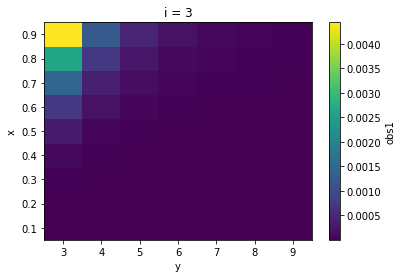

AttributeError: 'Dataset' object has no attribute 'plot'

In [23]:
results['obs1'].sel(i=3).plot()
plt.show()
results.sel(y=[4,6]).plot.line(x='x')
plt.show()
print(results)

In [21]:
results['obs1']

<xarray.DataArray 'obs1' (i: 12, x: 9, y: 7)>
array([[[1.000000e+00, 1.000000e+00, ..., 1.000000e+00, 1.000000e+00],
        [1.000000e+00, 1.000000e+00, ..., 1.000000e+00, 1.000000e+00],
        ...,
        [1.000000e+00, 1.000000e+00, ..., 1.000000e+00, 1.000000e+00],
        [1.000000e+00, 1.000000e+00, ..., 1.000000e+00, 1.000000e+00]],

       [[6.085806e-03, 3.952847e-03, ..., 1.397542e-03, 1.171214e-03],
        [1.721326e-02, 1.118034e-02, ..., 3.952847e-03, 3.312693e-03],
        ...,
        [1.377061e-01, 8.944272e-02, ..., 3.162278e-02, 2.650155e-02],
        [1.643168e-01, 1.067269e-01, ..., 3.773365e-02, 3.162278e-02]],

       ...,

       [[6.969172e-23, 9.313226e-25, ..., 2.842171e-29, 4.856936e-30],
        [2.283658e-18, 3.051758e-20, ..., 9.313226e-25, 1.591521e-25],
        ...,
        [2.452059e-09, 3.276800e-11, ..., 1.000000e-15, 1.708882e-16],
        [1.434891e-08, 1.917511e-10, ..., 5.851778e-15, 1.000000e-15]],

       [[4.241303e-25, 3.681376e-27, ..., 3.